In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:

df = pd.read_csv("startup_dataset.csv", low_memory=False)

df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')

print("Funding column converted.")
print(df['funding_total_usd'].describe())

missing_percentage = df['funding_total_usd'].isna().mean() * 100
print(f"Missing Funding Percentage: {missing_percentage:.2f}%")

# ================================
# CONVERT DATE COLUMNS
# ================================

df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')

print("Date columns converted.")
df['founded_at'].isna().mean() * 100
missing_founded = df['founded_at'].isna().mean() * 100
print(f"Missing Founded Date Percentage: {missing_founded:.2f}%")

# =================================
# CREATE CLEAN WORKING DATASET
# =================================

analysis_df = df[
    (df['funding_total_usd'].notna()) &
    (df['founded_at'].notna())
].copy()

print("Original shape:", df.shape)
print("Cleaned shape:", analysis_df.shape)

# =================================
# CREATE FAILURE VARIABLE
# =================================

analysis_df['failure'] = np.where(analysis_df['status'] == 'closed', 1, 0)

print(analysis_df['failure'].value_counts())

# =================================
# CREATE SURVIVAL DURATION
# =================================

today = pd.to_datetime("today")

analysis_df['end_date'] = np.where(
    analysis_df['failure'] == 1,
    analysis_df['last_funding_at'],
    today
)

analysis_df['end_date'] = pd.to_datetime(analysis_df['end_date'], errors='coerce')

analysis_df['survival_years'] = (
    (analysis_df['end_date'] - analysis_df['founded_at']).dt.days
) / 365

print(analysis_df['survival_years'].describe())

# =================================
# FIX SURVIVAL LOGIC
# =================================

# Remove rows where end_date is earlier than founded_at
analysis_df = analysis_df[
    analysis_df['end_date'] >= analysis_df['founded_at']
]

# Remove unrealistic survival values
analysis_df = analysis_df[
    (analysis_df['survival_years'] >= 0) &
    (analysis_df['survival_years'] <= 50)
]

Funding column converted.
count    5.358300e+04
mean     1.847860e+07
std      1.880133e+08
min      1.000000e+00
25%      3.356235e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64
Missing Funding Percentage: 19.26%
Date columns converted.
Missing Founded Date Percentage: 22.94%
Original shape: (66368, 14)
Cleaned shape: (41887, 14)
failure
0    38599
1     3288
Name: count, dtype: int64
count    41887.000000
mean        17.216105
std         11.349642
min        -79.021918
25%         13.167123
50%         15.169863
75%         19.758904
max        277.342466
Name: survival_years, dtype: float64


In [3]:
analysis_df = pd.read_csv("startup_dataset.csv")
analysis_df.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


# Exploratory Data Analysis

In [1]:
# Features and target
X = analysis_df[['funding_total_usd', 'survival_years']]
y = analysis_df['failure']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Results
print(classification_report(y_test, y_pred))

NameError: name 'analysis_df' is not defined

In [5]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

NameError: name 'X_train' is not defined

In [ ]:
analysis_df.groupby('failure')['funding_rounds'].describe()

,count,mean,std,min,25%,50%,75%,max
failure,,,,,,,,
0,38193.0,2.051659,1.578795,1.0,1.0,1.0,3.0,19.0
1,3053.0,1.617753,1.163124,1.0,1.0,1.0,2.0,14.0


In [ ]:
analysis_df.groupby('funding_rounds')['failure'].mean().sort_index().head(10)

funding_rounds
1     0.092425
2     0.068766
3     0.043892
4     0.041478
5     0.032787
6     0.031989
7     0.028061
8     0.055000
9     0.043103
10    0.013889
Name: failure, dtype: float64

In [ ]:
analysis_df['high_rounds'] = analysis_df['funding_rounds'] >= 3

In [ ]:
analysis_df['round_category'] = analysis_df['funding_rounds'].apply(lambda x: 'Low (<3)' if x < 3 else 'High (>=3)')

analysis_df.groupby('round_category')['failure'].mean()

round_category
High (>=3)    0.040121
Low (<3)      0.085184
Name: failure, dtype: float64

# ---------------------------------
# Logistic Regression V2
# Added funding_rounds feature
# ---------------------------------

In [ ]:
X = analysis_df[['funding_total_usd', 'survival_years', 'funding_rounds']]
y = analysis_df['failure']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     11465
           1       0.56      0.03      0.06       909

    accuracy                           0.93     12374
   macro avg       0.74      0.51      0.51     12374
weighted avg       0.90      0.93      0.90     12374



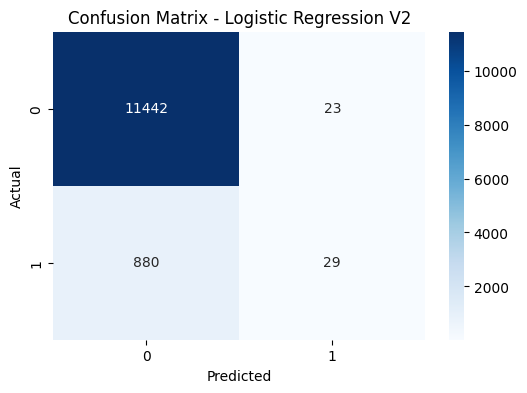

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression V2")
plt.show()

In [ ]:
import pandas as pd

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

coefficients.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
0,funding_total_usd,2.619690e-09
2,funding_rounds,-2.073351e-03
1,survival_years,-1.069795e-01


In [ ]:
analysis_df['failure_probability'] = model.predict_proba(X)[:,1]

analysis_df[['funding_rounds','funding_total_usd','survival_years','failure_probability']].head()

,funding_rounds,funding_total_usd,survival_years,failure_probability
1,2,700000.0,11.484932,0.226073
3,1,2000000.0,19.164384,0.114388
6,2,762851.0,29.169863,0.042193
7,4,33600000.0,15.161644,0.176258
8,3,1150050.0,14.580822,0.173258


In [ ]:
analysis_df.to_csv("startup_final_dataset.csv", index=False)